**DATASET LINK** 

[Image](https://drive.google.com/file/d/1iBMeUPk8Uxa3I4r5ISLY66YTm28W7OHd/view?usp=sharing)

[Label](https://drive.google.com/file/d/1S_Eh56g7o1D4FpA55M3527Kf_vE4LvC0/view?usp=sharing)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from tensorflow.random import set_seed
set_seed(1612)
import numpy as np
np.random.seed(1612)
import matplotlib.pyplot as plt
import os
from skimage import draw

# Excercise: Bounding Box Regressor

## Goal

Học được cách sử dụng các Pretrained Model có sẵn do Tensorflow cung cấp

## Prepare Dataset



Bài tập này chúng ta sẽ tiến hành huấn luyện module xác định bounding box khoanh vùng mặt của một con mèo (Cat Face). Tập dữ liệu Cat Dataset bao gồm khoảng 10.000 được download tại trang web sau: https://web.archive.org/web/20150520175645/http://137.189.35.203/WebUI/CatDatabase/catData.html

Dưới đây là một số ảnh nằm trong dataset này.

![Một số ảnh mèo trong dataset](https://web.archive.org/web/20150520175645im_/http://137.189.35.203/WebUI/CatDatabase/Samples.jpg)

**Annotation:**
Dataset gồm có 7 thư mục ảnh 'CAT_00' đến 'CAT_06'. Trong các thư mục ảnh này sẽ có một cặp file có cùng tên khác phần mở rộng tương ứng là ảnh gốc và file chứa các điểm gán nhãn. Ví dụ như cặp file (00000003_015.jpg , 00000003_015.jpg.cat). File .cat sẽ có 9 cặp điểm tương ứng với các bộ phận trên mặt của một con mèo như: đỉnh tai, mắt, mũi, miệng, ...
Lưu ý rằng trong bài toán phát hiện mặt mèo này, chúng ta không cần thông tin của các đỉnh này mà chỉ cần quan tâm đến đường bao (bounding box) xung quanh mặt của một con mèo được tạo dựa trên các đỉnh này.

![cat annotation](https://web.archive.org/web/20150520175645im_/http://137.189.35.203/WebUI/CatDatabase/annotation.png)


**Constansts**

In [ ]:
# TODO

CURRENT_DIR = '/content/drive/My Drive/Colab Notebooks/AI Practitioner - 2020/Files'

PATH_TO_X = '/content/drive/My Drive/Colab Notebooks/AI Practitioner - 2020/Files/data_X.pkl'
PATH_TO_Y = '/content/drive/My Drive/Colab Notebooks/AI Practitioner - 2020/Files/data_y.pkl'

SAVE_WEIGHTS_FILEPATH = os.path.join(CURRENT_DIR, 'best_weights', 'best_model')
SAVE_WEIGHTS_CHECKPOINT_FILEPATH = os.path.join(CURRENT_DIR, 'ckp', 'weights.{epoch:02d}-{val_loss:.2f}') # lưu epoch với val loss riêng

**Load dữ liệu từ file pickle**

In [ ]:
# TODO
# 1. Google search "How to load data with pickle"
# 2. Complete load_data() function below
# 3. Call load_data() function for X and y
# import pickle
# filehandler = open(b"Fruits.obj","wb")
# pickle.dump(banana,filehandler)
# filehandler.close()

import pickle              # import module first
mydict_X = open(PATH_TO_X, 'rb')   # 'rb' for reading binary or 'wb'
mydict_Y = open(PATH_TO_Y, 'rb')
X = pickle.load(mydict_X)         # load file content as mydict
Y = pickle.load(mydict_Y)         # load file content as mydict
mydict_X.close()   
mydict_Y.close()

**Kiểm tra dữ liệu**

In [ ]:
# TODOs
MODEL_IMAGE_HEIGHT = 128 
MODEL_IMAGE_WIDTH = 128
print('Shape of data:', X.shape, Y.shape)

Shape of data: (8784, 128, 128, 3) (8784, 4)


**Các hàm hỗ trợ**

Một số hàm cơ bản phục vụ cho quá trình huấn luyện như:
- plot_learning_curve: vẽ learning curve trên tập Train và Validation sau khi huấn luyện.
- unnormalize_prediction: biến đổi vector output đầu ra thành dạng toạ độ ảnh hệ toạ độ nguyên theo pixel. Bước này là để khôi phục hệ toạ độ bounding box từ dạng đã chuẩn hoá (normalized) có miền giá trị 0-1 sang hệ toạ độ theo pixel của ảnh trong tập dữ liệu.
- draw_predicted_rectangle: vẽ bounding box dự đoán từ hệ thống lên ảnh. Bước này bao gồm việc chuẩn hoá ngược sang hệ pixel và vẽ lên trên ảnh màu.
- clip: để đảm bảo rằng toạ độ đều không âm và không vượt quá khuôn khổ ảnh.



Label:

top left       -   center x

top right      -   center y

bottom left   -    half width

bottom right   -   half height

In [ ]:
def plot_learning_curve(history):
  plt.figure(figsize=(20,10))
  plt.subplot(1,2,1)
  plt.plot(history.history['loss'], label='Loss')
  plt.plot(history.history['val_loss'], label ='Validation Loss')
  plt.legend(loc='upper rights')
  plt.title('Loss vs Epoch')
  plt.show()

def unnormalize_prediction(y, x, half_height, half_width, \
                           img_height=MODEL_IMAGE_HEIGHT, img_width=MODEL_IMAGE_WIDTH):
    """Transforms a predictions from normalized (0 to 1) y, x, half-width,
    half-height to pixel values (top left y, top left x, bottom right y,
    bottom right x).
    Args:
        y: Normalized y coordinate of rectangle center.
        x: Normalized x coordinate of rectangle center.
        half_height: Normalized height of rectangle.
        half_width: Normalized width of rectangle.
        img_height: Height of the image to use while unnormalizing.
        img_width: Width of the image to use while unnormalizing.
    Returns:
        (top left y in px, top left x in px, bottom right y in px,
        bottom right x in px)
    """
    # calculate x, y of corners in pixels (x, y là toạ độ của center)
    tl_y = int((y - half_height) * img_height)
    tl_x = int((x - half_width) * img_width)
    br_y = int((y + half_height) * img_height)
    br_x = int((x + half_width) * img_width)

    # make sure that x and y coordinates are within image boundaries
    tl_y = clip(0, tl_y, img_height-2)
    tl_x = clip(0, tl_x, img_width-2)
    br_y = clip(0, br_y, img_height-1)
    br_x = clip(0, br_x, img_width-1)

    # make sure that top left corner is really top left of bottom right values
    if tl_y > br_y:
        tl_y, br_y = br_y, tl_y
    if tl_x > br_x:
        tl_x, br_x = br_x, tl_x

    # make sure that the area covered is at least 1px,
    # move preferably the top left corner
    # but dont move it outside of the image
    if tl_y == br_y:
        if tl_y == 0:
            br_y += 1
        else:
            tl_y -= 1

    if tl_x == br_x:
        if tl_x == 0:
            br_x += 1
        else:
            tl_x -= 1

    return tl_y, tl_x, br_y, br_x

def draw_predicted_rectangle(image_arr, y, x, half_height, half_width):
    """Draws a rectangle onto the image at the provided coordinates.
    Args:
        image_arr: Numpy array of the image.
        y: y-coordinate of the rectangle (normalized to 0-1).
        x: x-coordinate of the rectangle (normalized to 0-1).
        half_height: Half of the height of the rectangle (normalized to 0-1).
        half_width: Half of the width of the rectangle (normalized to 0-1).
    Returns:
        Modified image (numpy array)
    """
    height = image_arr.shape[0]
    width = image_arr.shape[1]
    tl_y, tl_x, br_y, br_x = unnormalize_prediction(y, x, half_height, half_width, \
                                                    img_height=height, img_width=width)
    image_arr = np.copy(image_arr) * 255
    return draw_rectangle(image_arr, tl_y, tl_x, br_y, br_x)

def draw_rectangle(img, tl_y, tl_x, br_y, br_x):
    """Draws a rectangle onto an image.
    Args:
        img: The image as a numpy array of shape (row, col, channel).
        tl_y: Top left y coordinate as pixel.
        tl_x: Top left x coordinate as pixel.
        br_y: Top left y coordinate as pixel.
        br_x: Top left x coordinate as pixel.
    Returns:
        image with rectangle
    """
    assert img.shape[2] == 3, img.shape[2]
    img = np.copy(img)
    lines = [
        (tl_y, tl_x, tl_y, br_x), # top left to top right
        (tl_y, br_x, br_y, br_x), # top right to bottom right
        (br_y, br_x, br_y, tl_x), # bottom right to bottom left
        (br_y, tl_x, tl_y, tl_x)  # bottom left to top left
    ]
    for y0, x0, y1, x1 in lines:
        rr, cc, val = draw.line_aa(y0, x0, y1, x1)
        img[rr, cc, 0] = val * 255

    return img.astype(np.uint8)

def clip(lower, val, upper):
    """Clips a value. For lower bound L, upper bound U and value V it
    makes sure that L <= V <= U holds.
    Args:
        lower: Lower boundary (including)
        val: The value to clip
        upper: Upper boundary (including)
    Returns:
        value within bounds
    """
    if val < lower:
        return lower
    elif val > upper:
        return upper
    else:
        return val




**Train Test Split**

In [ ]:
# TODO
# Split to 3 Sets
# Test = Validation = 0.2
# Ko phải Classification nên ko cần stratify=y or y_test
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.4, shuffle=True, random_state=1612) # phải có stratifY=Y để cân bằng dữ liệu. Nên ktra np.unique
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test,test_size=.5, shuffle=True, random_state=1612) # stratify bằng y_train or test đều đc

In [ ]:
X_train.shape

(5270, 128, 128, 3)

## Visualize Data

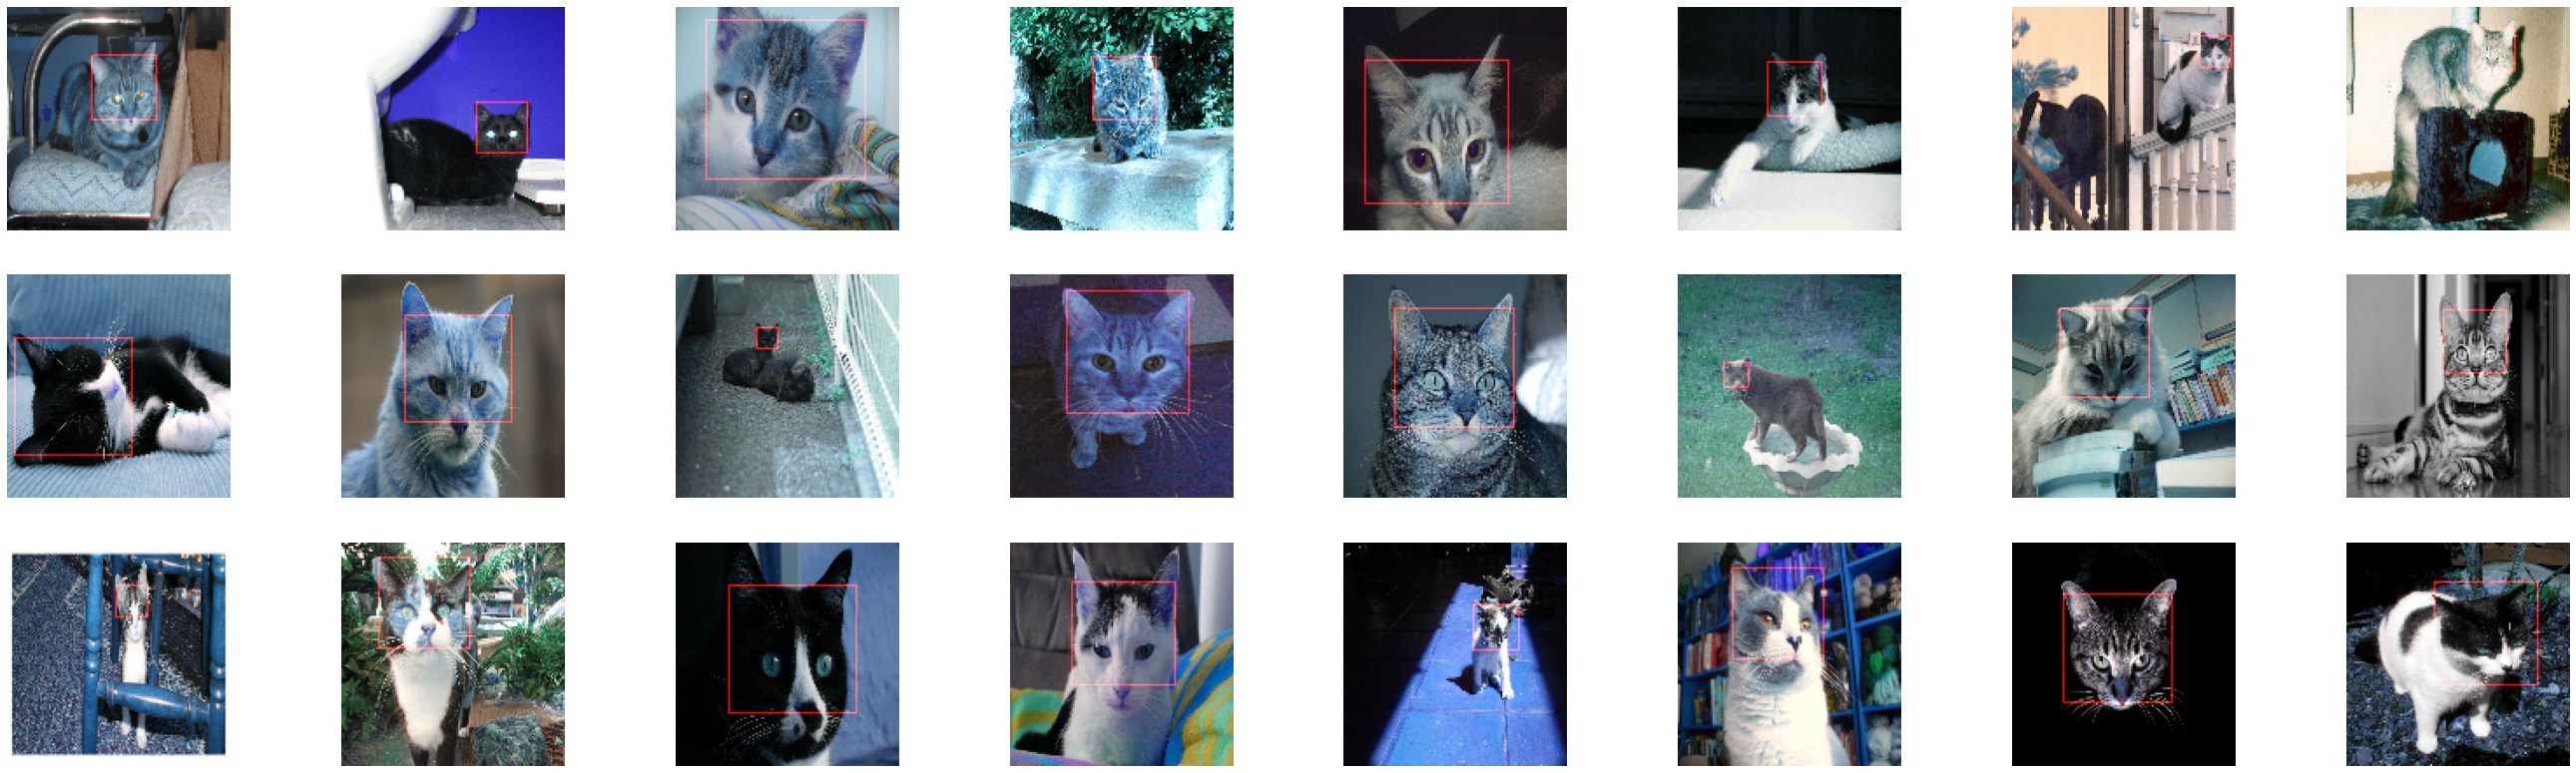

In [ ]:
cols = 8
rows = 3
fig, axs = plt.subplots(rows,cols,figsize=(6 * cols - 1, 5 * rows - 1))
for i in range(rows):
  for j in range(cols):
    target = np.random.choice(Y.shape[0])
    axs[i][j].grid('off')
    axs[i][j].axis('off')
    axs[i][j].imshow(np.squeeze(X[target]), cmap='gray')
    temp = X[target]
    temp_y = Y[target]
    img = draw_predicted_rectangle(temp, temp_y[0], temp_y[1], temp_y[2], temp_y[3])
    axs[i][j].imshow(img)
plt.show()

## Create and Train Model

In [ ]:
# from tensorflow.keras.models import *
# from tensorflow.keras.layers import *
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping # sau mỗi epoch thì lưu 1 bộ trọng số lại

# from tensorflow.keras.applications import ResNet50 #  app nhiều kiểu  # https://www.tensorflow.org/api_docs/python/tf/keras/applications
# from tensorflow.keras.applications.resnet50 import preprocess_input

# def create_model(image_height, image_width, loss, optimizer):
#   input = Input(shape=(image_height, image_width, 3)) # channels: colored image
#   x = preprocess_input(input) # end-to-end learning # scale hình bên trong hàm # chia 255 scale về 0 1
#   pretrained_model = ResNet50(
#       include_top=False,
#       weights='imagenet',
#       input_shape=(image_height, image_width, 3))  # fully connected dẹp luôn. Chừa lại feature extraction (top là khúc ngoài sau). model.summary sau khi bỏ cell ngoài
#   pretrained_model.trainable = False # đang dùng ko train lại. Fit trọng số lại. Train phần sau thôi

#   x = pretrained_model(x, training=False)
#   x = GlobalAvergePooling2D()(x) # Flatten : giảm bớt params ở cuối

#   x = Dense(512, kernel_initializer='he_uniform')(x) # phân phối đều # relu thì he # sigmoid or tanh thì xài savior / cross ??
#   x = Dropout(0.5)(x)
#   x = Activation('relu')(x)
#   output = Dense(4, actition='linear')(x) # regression nên là linear # 4 con số

#   model = Model(input, output)
#   model.compile(loss=loss, optimizer=optimizer)
#   model.summary()
#   return model

In [ ]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping # sau mỗi epoch thì lưu 1 bộ trọng số lại
from tensorflow.keras.applications import ResNet50 #  app nhiều kiểu  # https://www.tensorflow.org/api_docs/python/tf/keras/applications
from tensorflow.keras.applications.resnet import preprocess_input
def create_model(image_width, image_height, loss, optimizer):
  input = Input(shape=(image_width, image_height,3)) # channels: colored image
  x = preprocess_input(input)  # end-to-end learning # scale hình bên trong hàm # chia 255 scale về 0 1
  pretrained_model = ResNet50(include_top=False, weights="imagenet",
                           input_shape=(image_width, image_height, 3)) # fully connected dẹp luôn. Chừa lại feature extraction (top là khúc ngoài sau). model.summary sau khi bỏ cell ngoài
  pretrained_model.trainable = False # đang dùng ko train lại. Fit trọng số lại. Train phần sau thôi
  x = pretrained_model(x, training=False)
  x = GlobalAveragePooling2D()(x) # có thể thay bằng Flatten # Flatten : giảm bớt params ở cuối
  x = Dense(512, kernel_initializer='he_uniform')(x) # phân phối đều # relu thì he # sigmoid or tanh thì xài savior / cross ??
  x = Dropout(0.5)(x)
  x = Activation('relu')(x)
  output = Dense(4, activation='linear')(x) # regression nên là linear # 4 con số
  model = Model(input, output)
  model.compile(loss=loss, optimizer=optimizer)
  model.summary()
  return model

In [ ]:
# TODO
# Call create_model()
model = create_model(MODEL_IMAGE_HEIGHT, MODEL_IMAGE_WIDTH, 'mse', 'adam')

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf_op_layer_strided_slice_7  [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd_7 (Tenso [(None, 128, 128, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)              

**Train Model**

In [ ]:
checkpoint_cb = ModelCheckpoint(SAVE_WEIGHTS_CHECKPOINT_FILEPATH, verbose=0, 
                                save_weights_only=True, save_freq='epoch') # hết mỗi epoch save 1 lần

stop_cb = EarlyStopping(monitor='val_loss', patience=15, verbose=0, 
                        restore_best_weights=True)

# TODO
# Fit model
history = model.fit(X_train, Y_train, batch_size=64, epochs=5, validation_data=(X_val, Y_val), verbose=2,
                    callbacks=[stop_cb] 
                    ) # checkpoint sẽ lưu hết bộ nhớ drive

Epoch 1/5
83/83 - 18s - loss: 0.0182 - val_loss: 0.0099
Epoch 2/5
83/83 - 16s - loss: 0.0137 - val_loss: 0.0095
Epoch 3/5
83/83 - 16s - loss: 0.0132 - val_loss: 0.0092
Epoch 4/5
83/83 - 16s - loss: 0.0124 - val_loss: 0.0094
Epoch 5/5
83/83 - 16s - loss: 0.0123 - val_loss: 0.0092


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Unrecognized location 'upper rights'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


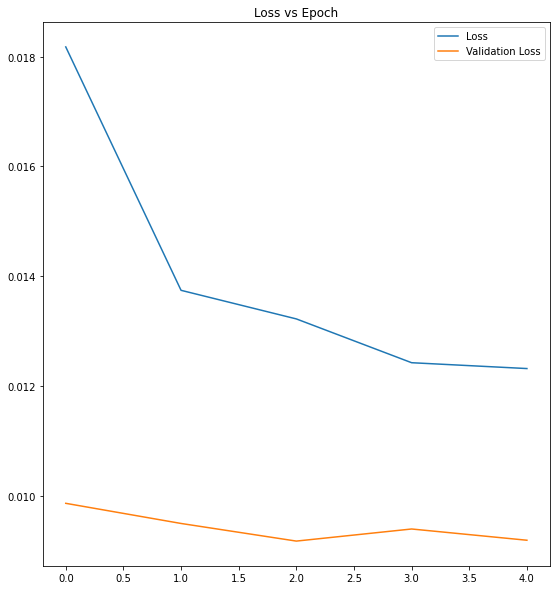

In [ ]:
# TODO
# Call plot_learning_curve()
plot_learning_curve(history)

In [ ]:
# TODO
# Evaluate on 3 Set
model.evaluate(X_test, Y_test)
model.evaluate(X_val, Y_val)
model.evaluate(X_train, Y_train)

165/165 [==============================] - 14s 83ms/step - loss: 0.0094


0.00939968042075634

## Inference

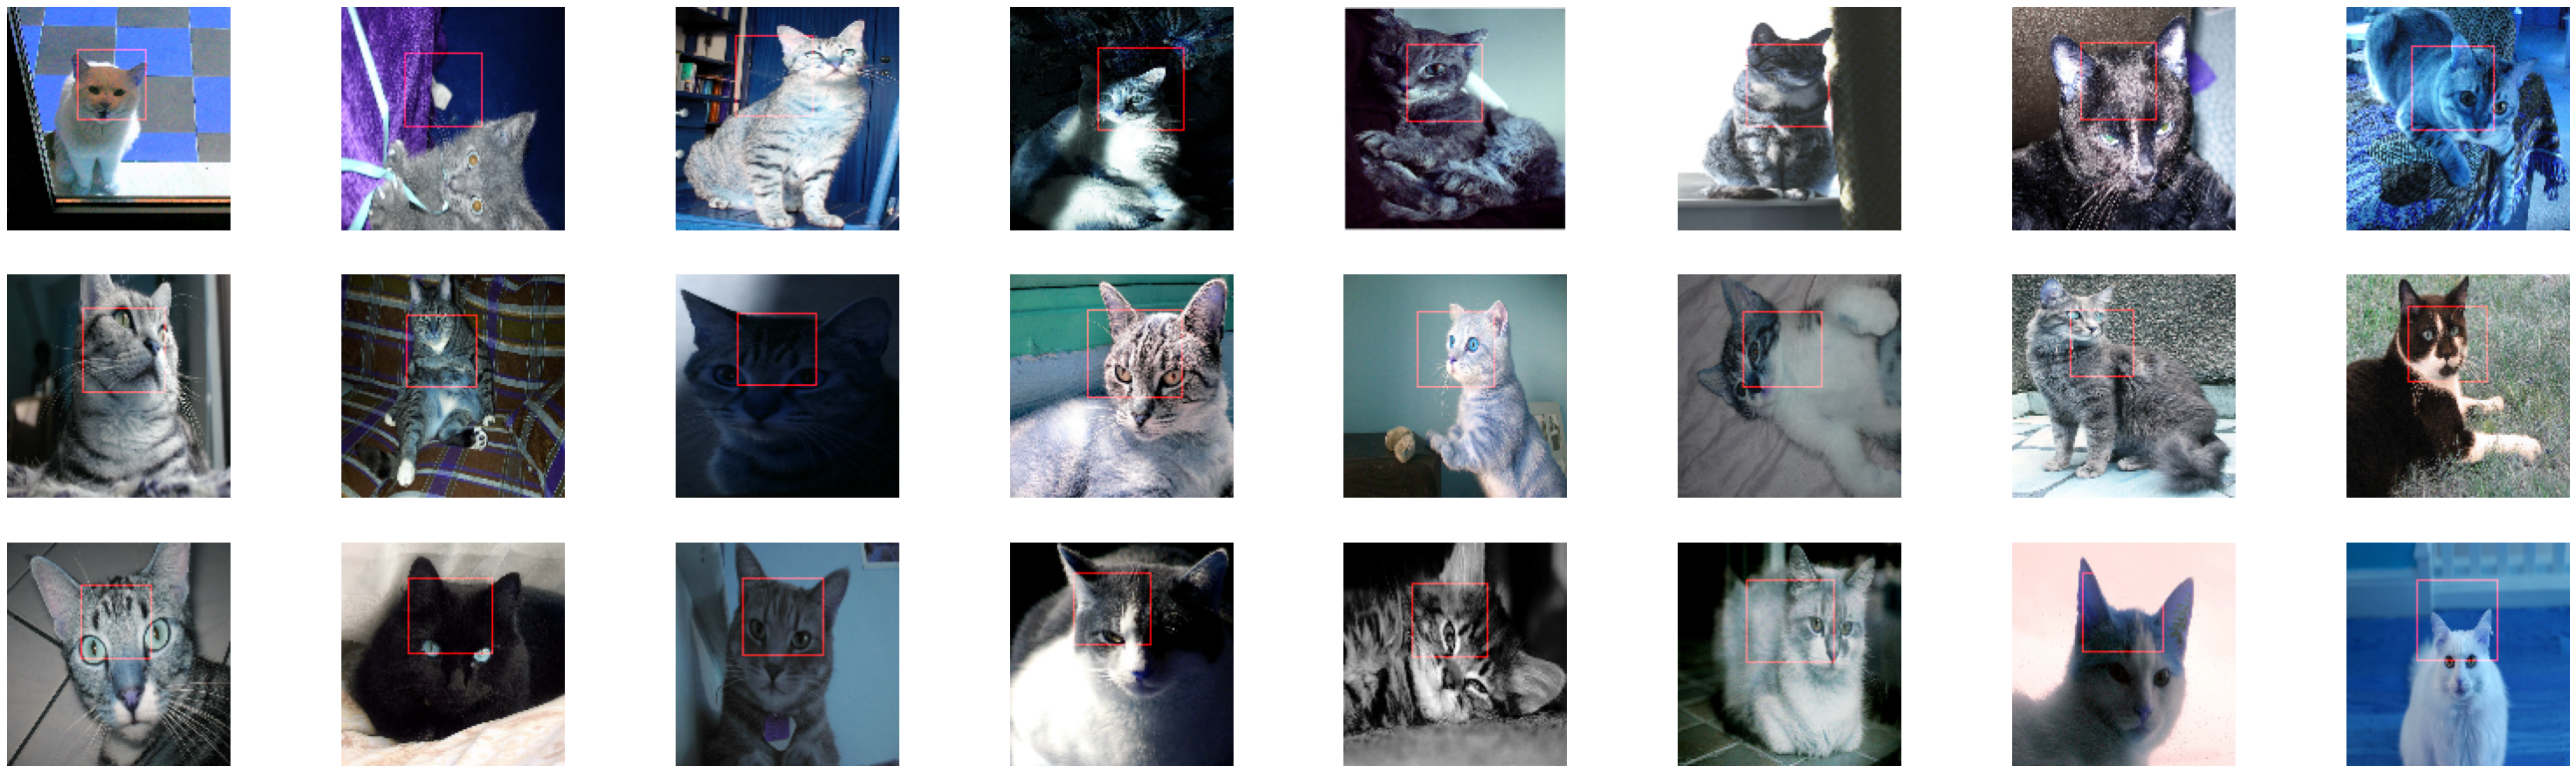

In [ ]:
# TODO
cols = 8
rows = 3
fig = plt.figure(figsize=(6 * cols - 1, 5 * rows - 1))
for i in range(cols):
  for j in range(rows):
    random_index = np.random.randint(0, X_test.shape[0])
    ax = fig.add_subplot(rows, cols, i * rows + j + 1)
    ax.grid('off')
    ax.axis('off')
    temp = X_test[random_index,:] # lấy hết 
    y_pred = model.predict(temp.reshape(1, MODEL_IMAGE_WIDTH, MODEL_IMAGE_HEIGHT, 3)) 
    img = draw_predicted_rectangle(temp, y_pred[0,0], y_pred[0,1], y_pred[0,2], y_pred[0,3]) # phải thêm 0 trước thì mới run đc # truyền thêm 1 chiều vô nữa chứ ko chỉ số 3
    ax.imshow(img) # model trả ra 1,4 nên phải có số 0 ở trước
plt.show()
plt.show()

In [ ]:
# Train layer cuối thôi nên chưa tốt --> xài Transfer Learning mở ra toàn bộ layer đằng trước thì tốt hơn 